# ANÁLISE DE ACESSIBILIDADE EM TERESINA - ATRIBUIÇÃO DE VELOCIDADES
# Autor: Felipe Ramos Dantas
# Data: 23/01/2026

In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# from shapely.geometry import Point, LineString, Polygon
import numpy as np
import warnings

# Suprimir warnings para manter o output limpo (usar com cautela)
warnings.filterwarnings('ignore')

# Configuração para plots mais legíveis
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [2]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# Definir caminho do arquivo GraphML
caminho_rede = '../dados/brutos/osmnx/rede_teresina.graphml'

try:
    # Carregar a rede pré-downloadada
    G = ox.io.load_graphml(caminho_rede)
    print(f"✅ Rede carregada com sucesso de: {caminho_rede}")
    
except FileNotFoundError:
    print(f"❌ Arquivo não encontrado: {caminho_rede}")
    print("Execute primeiro o notebook 01_download_rede.ipynb")
    # Criar grafo vazio para evitar erros nas células seguintes
    G = nx.MultiDiGraph()

✅ Rede carregada com sucesso de: ../dados/brutos/osmnx/rede_teresina.graphml


In [ ]:
# ============================================
# VERIFICAÇÃO BÁSICA DA ESTRUTURA DA REDE
# ============================================

if len(G.nodes) > 0:
    print(f"Número de nós: {len(G.nodes):,}")
    print(f"Número de arestas: {len(G.edges):,}")
    
    # Verificar atributos das arestas
    print("\nAtributos das arestas (primeira aresta):")
    primeira_aresta = list(G.edges(data=True))[0]
    print(f"Chaves dos atributos: {list(primeira_aresta[2].keys())}")
    
    # Estatísticas básicas de comprimento
    comprimentos = [data['length'] for _, _, data in G.edges(data=True) if 'length' in data]
    if comprimentos:
        print("\nEstatísticas de comprimento das arestas:")
        print(f"  • Mínimo: {np.min(comprimentos):.2f} m")
        print(f"  • Médio: {np.mean(comprimentos):.2f} m")
        print(f"  • Máximo: {np.max(comprimentos):.2f} m")
else:
    print("⚠️ Grafo vazio - verifique o carregamento dos dados")

Número de nós: 32,142
Número de arestas: 90,912

Atributos das arestas (primeira aresta):
Chaves dos atributos: ['osmid', 'highway', 'ref', 'oneway', 'reversed', 'length', 'bridge', 'name', 'geometry']

Estatísticas de comprimento das arestas:
  • Mínimo: 0.57 m
  • Médio: 107.45 m
  • Máximo: 5218.91 m


In [4]:
# ============================================
# CONVERSÃO PARA GEODATAFRAMES
# ============================================

# Converter o grafo para GeoDataFrames (nós e arestas)
# NOTA: O método graph_to_gdfs retorna (nós, arestas)
if len(G.nodes) > 0:
    try:
        nodes_gdf, edges_gdf = ox.convert.graph_to_gdfs(G)
        print("✅ Conversão para GeoDataFrames realizada com sucesso")
    except Exception as e:
        print(f"❌ Erro na conversão: {e}")
        # Criar GeoDataFrames vazios para continuidade
        nodes_gdf = gpd.GeoDataFrame()
        edges_gdf = gpd.GeoDataFrame()
else:
    nodes_gdf = gpd.GeoDataFrame()
    edges_gdf = gpd.GeoDataFrame()

✅ Conversão para GeoDataFrames realizada com sucesso


In [5]:
nodes_gdf.head(3)

,y,x,street_count,highway,railway,geometry
osmid,,,,,,
320563363,-5.128435,-42.806767,3,NaN,NaN,POINT (-42.80677 -5.12844)
320663404,-5.132189,-42.821560,3,NaN,NaN,POINT (-42.82156 -5.13219)
320664462,-5.130940,-42.811625,3,NaN,NaN,POINT (-42.81162 -5.13094)


In [6]:
# ============================================
# PREPARAÇÃO DOS DATAFRAMES
# ============================================

# Resetar índices para facilitar manipulação
if not nodes_gdf.empty:
    nodes_gdf = nodes_gdf.reset_index()
    edges_gdf = edges_gdf.reset_index()
    print("✅ Índices resetados")
    
    # Mostrar estrutura dos dados
    print(f"\nEstrutura de nodes_gdf: {nodes_gdf.shape[0]} linhas × {nodes_gdf.shape[1]} colunas")
    print(f"Estrutura de edges_gdf: {edges_gdf.shape[0]} linhas × {edges_gdf.shape[1]} colunas")
else:
    print("⚠️ GeoDataFrames vazios - pulando reset")

✅ Índices resetados

Estrutura de nodes_gdf: 32142 linhas × 7 colunas
Estrutura de edges_gdf: 90912 linhas × 18 colunas


In [ ]:
# ============================================
# VISUALIZAÇÃO DOS DADOS DE NÓS
# ============================================

if not nodes_gdf.empty:
    print("Primeiras 3 linhas de nodes_gdf:")
    display(nodes_gdf.head(3))
    
    # Informações sobre coordenadas
    print("\nExtensão geográfica dos nós:")
    print(f"  • Latitude: {nodes_gdf['y'].min():.6f} a {nodes_gdf['y'].max():.6f}")
    print(f"  • Longitude: {nodes_gdf['x'].min():.6f} a {nodes_gdf['x'].max():.6f}")
else:
    print("⚠️ Sem dados de nós para exibir")

Primeiras 3 linhas de nodes_gdf:


,osmid,y,x,street_count,highway,railway,geometry
0,320563363,-5.128435,-42.806767,3,NaN,NaN,POINT (-42.80677 -5.12844)
1,320663404,-5.132189,-42.821560,3,NaN,NaN,POINT (-42.82156 -5.13219)
2,320664462,-5.130940,-42.811625,3,NaN,NaN,POINT (-42.81162 -5.13094)



Extensão geográfica dos nós:
  • Latitude: -5.259043 a -4.929533
  • Longitude: -42.863167 a -42.626263


In [ ]:
# ============================================
# VISUALIZAÇÃO DOS DADOS DE ARESTAS
# ============================================

if not edges_gdf.empty:
    print("Primeiras 3 linhas de edges_gdf:")
    display(edges_gdf.head(3))
    
    # Contar valores ausentes em colunas importantes
    colunas_importantes = ['highway', 'length', 'name', 'maxspeed']
    print("\nValores ausentes em colunas importantes:")
    for col in colunas_importantes:
        if col in edges_gdf.columns:
            nulos = edges_gdf[col].isna().sum()
            total = len(edges_gdf)
            print(f"  • {col}: {nulos:,} nulos ({nulos/total*100:.1f}%)")
else:
    print("⚠️ Sem dados de arestas para exibir")

Primeiras 3 linhas de edges_gdf:


,u,v,key,osmid,highway,ref,oneway,reversed,length,bridge,name,geometry,maxspeed,junction,lanes,access,width,area
0,320563363,7173944767,0,"[29152809, 29152796, 29152807]",trunk,"[BR-226;BR-316, BR-316]",False,True,1359.928740,yes,Ponte Engenheiro Antônio Noronha,"LINESTRING (-42.80677 -5.12844, -42.80708 -5.1...",NaN,NaN,NaN,NaN,NaN,NaN
1,320563363,7180675058,0,29152940,trunk,BR-316,True,False,85.726693,NaN,Avenida Getúlio Vargas,"LINESTRING (-42.80677 -5.12844, -42.80636 -5.1...",NaN,NaN,NaN,NaN,NaN,NaN
2,320663404,1682447780,0,29152765,trunk,NaN,True,False,42.339460,NaN,Avenida Presidente Médici,"LINESTRING (-42.82156 -5.13219, -42.8217 -5.13...",NaN,NaN,NaN,NaN,NaN,NaN



Valores ausentes em colunas importantes:
  • highway: 0 nulos (0.0%)
  • length: 0 nulos (0.0%)
  • name: 17,960 nulos (19.8%)
  • maxspeed: 83,697 nulos (92.1%)


In [ ]:
# ============================================
# ANÁLISE E LIMPEZA DA COLUNA 'HIGHWAY'
# ============================================

if not edges_gdf.empty and 'highway' in edges_gdf.columns:
    # Analisar distribuição de tipos de dados
    print("Distribuição dos tipos de dados na coluna 'highway':")
    contagem_tipos = edges_gdf['highway'].apply(lambda x: type(x).__name__).value_counts()
    
    for tipo, contagem in contagem_tipos.items():
        print(f"  • {tipo}: {contagem:,} arestas ({contagem/len(edges_gdf)*100:.1f}%)")
    
    # Função para extrair tipo de via principal
    def extrair_tipo_via(valor):
        """
        Extrai o tipo de via principal da coluna 'highway'.
        
        Parâmetros:
        -----------
        valor : str, list ou None
            Valor da coluna 'highway'
            
        Retorna:
        --------
        str ou None
            Tipo de via principal
        """
        if isinstance(valor, list):
            # Para listas, pegar primeiro elemento (classificação principal)
            return valor[0] if len(valor) > 0 else None
        elif isinstance(valor, str):
            return valor
        else:
            return None
    
    # Aplicar função para criar coluna limpa
    edges_gdf['highway_clean'] = edges_gdf['highway'].apply(extrair_tipo_via)
    
    # Verificar valores únicos após limpeza
    tipos_unicos = edges_gdf['highway_clean'].dropna().unique()
    print(f"\nTipos de via únicos após limpeza ({len(tipos_unicos)} tipos):")
    print(sorted(tipos_unicos))
    
    # Distribuição dos tipos mais comuns
    print("\nTop 10 tipos de via mais frequentes:")
    top10 = edges_gdf['highway_clean'].value_counts().head(10)
    for tipo, count in top10.items():
        print(f"  • {tipo}: {count:,} arestas ({count/len(edges_gdf)*100:.1f}%)")
else:
    print("⚠️ Coluna 'highway' não encontrada ou DataFrame vazio")

Distribuição dos tipos de dados na coluna 'highway':
  • str: 90,861 arestas (99.9%)
  • list: 51 arestas (0.1%)

Tipos de via únicos após limpeza (12 tipos):
['busway', 'living_street', 'primary', 'primary_link', 'residential', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'trunk', 'trunk_link', 'unclassified']

Top 10 tipos de via mais frequentes:
  • residential: 72,906 arestas (80.2%)
  • tertiary: 6,695 arestas (7.4%)
  • secondary: 3,636 arestas (4.0%)
  • unclassified: 3,121 arestas (3.4%)
  • primary: 2,354 arestas (2.6%)
  • living_street: 932 arestas (1.0%)
  • trunk: 541 arestas (0.6%)
  • primary_link: 264 arestas (0.3%)
  • secondary_link: 247 arestas (0.3%)
  • tertiary_link: 114 arestas (0.1%)


In [10]:
# ============================================
# DEFINIÇÃO DOS PERFIS DE VELOCIDADE
# ============================================
# Baseado em: https://wiki.openstreetmap.org/wiki/Key:highway
# Valores em km/h

# PERFIL PARA CARRO (veículo motorizado padrão)
velocidades_carro = {
    'motorway': 100, 'motorway_link': 60,
    'trunk': 80, 'trunk_link': 50,
    'primary': 60, 'primary_link': 40,
    'secondary': 50, 'secondary_link': 30,
    'tertiary': 40, 'tertiary_link': 20,
    'residential': 30, 'living_street': 10,
    'service': 20, 'unclassified': 30,
    'road': 30, 'busway': 30,
    'track': 20, 'path': 15,
    'footway': 15, 'pedestrian': 15,
    'steps': 5
}

# PERFIL PARA MOTO (considerando maior agilidade no trânsito)
velocidades_moto = {}
for via, vel in velocidades_carro.items():
    if 'motorway' in via or 'trunk' in via:
        velocidades_moto[via] = vel * 0.9  # 90% em vias rápidas (maior agilidade)
    elif 'link' in via:
        velocidades_moto[via] = vel * 1.1  # 110% em vias de conexão
    else:
        velocidades_moto[via] = vel * 1.0  # Mesma velocidade em vias urbanas

# PERFIL PARA A PÉ (caminhada - velocidade constante)
# Base: ~5 km/h (1.4 m/s) - ritmo moderado de caminhada
velocidades_pe = {
    'motorway': 0, 'motorway_link': 0,  # Inacessível a pedestres
    'trunk': 5, 'trunk_link': 5,
    'primary': 5, 'primary_link': 5,
    'secondary': 5, 'secondary_link': 5,
    'tertiary': 5, 'tertiary_link': 5,
    'residential': 5, 'living_street': 5,
    'service': 5, 'unclassified': 5,
    'road': 5, 'busway': 5,
    'track': 5, 'path': 5,
    'footway': 5, 'pedestrian': 5,
    'steps': 3  # Mais lento em escadas
}

print("✅ Perfis de velocidade definidos para três modos de transporte")
print(f"  • Carro: {len(velocidades_carro)} categorias de vias")
print(f"  • Moto: {len(velocidades_moto)} categorias de vias")
print(f"  • A pé: {len(velocidades_pe)} categorias de vias")

✅ Perfis de velocidade definidos para três modos de transporte
  • Carro: 21 categorias de vias
  • Moto: 21 categorias de vias
  • A pé: 21 categorias de vias


In [11]:
# ============================================
# FUNÇÃO DE ATRIBUIÇÃO DE VELOCIDADES
# ============================================

def atribuir_velocidades(grafo, dicionario_velocidades, nome_modo):
    """
    Atribui velocidades e tempos de viagem a todas as arestas do grafo
    baseado no tipo de via (highway).
    
    Parâmetros:
    -----------
    grafo : networkx.MultiDiGraph
        Grafo da rede viária
    dicionario_velocidades : dict
        Dicionário com velocidades por tipo de via
    nome_modo : str
        Nome do modo de transporte (ex: 'carro', 'moto', 'pe')
        
    Retorna:
    --------
    networkx.MultiDiGraph
        Grafo com velocidades e tempos de viagem atribuídos
    """
    
    G_modificado = grafo.copy()
    
    # Contadores para estatísticas
    atribuicoes = 0
    nao_encontrados = 0
    velocidade_zero = 0
    
    for u, v, k, data in G_modificado.edges(data=True, keys=True):
        # Obter tipo de via
        via_type = data.get('highway_clean', None)
        
        # Tratar caso seja lista (pegar primeira classificação)
        if isinstance(via_type, list):
            via_type = via_type[0] if via_type else None
        
        # Buscar velocidade no dicionário
        velocidade = None
        if via_type is not None:
            # Tentar match exato primeiro
            velocidade = dicionario_velocidades.get(via_type, None)
            
            # Se não encontrado, tentar match parcial
            if velocidade is None:
                for key in dicionario_velocidades.keys():
                    if key in str(via_type):
                        velocidade = dicionario_velocidades[key]
                        break
        
        # Se ainda não encontrou, usar valor padrão baseado no modo
        if velocidade is None:
            if nome_modo == 'pe':
                velocidade = 5  # Velocidade padrão para pedestres
            else:
                velocidade = 30  # Velocidade urbana padrão para veículos
            nao_encontrados += 1
        
        # Registrar velocidades zero (inacessíveis)
        if velocidade == 0:
            velocidade_zero += 1
        
        # Atribuir velocidade (km/h)
        G_modificado[u][v][k][f'speed_kph_{nome_modo}'] = velocidade
        
        # Calcular tempo de viagem (segundos)
        # Fórmula: tempo = distância (m) × 3.6 / velocidade (km/h)
        distancia = data.get('length', 0)
        if velocidade > 0:
            tempo_viagem = (distancia * 3.6) / velocidade
        else:
            tempo_viagem = float('inf')  # Inacessível
            
        G_modificado[u][v][k][f'travel_time_{nome_modo}'] = tempo_viagem
        atribuicoes += 1
    
    # Estatísticas
    print(f"  • Arestas processadas: {atribuicoes:,}")
    print(f"  • Tipos não encontrados: {nao_encontrados:,} ({nao_encontrados/atribuicoes*100:.1f}%)")
    print(f"  • Inacessíveis (vel=0): {velocidade_zero:,}")
    
    return G_modificado

In [20]:
# Verificar atributos das arestas
print("\nAtributos das arestas (primeira aresta):")
primeira_aresta = list(G.edges(data=True))[0]
print(f"Chaves dos atributos: {list(primeira_aresta[2].keys())}")


Atributos das arestas (primeira aresta):
Chaves dos atributos: ['osmid', 'highway', 'ref', 'oneway', 'reversed', 'length', 'bridge', 'name', 'geometry']


In [12]:
# ============================================
# APLICAÇÃO DOS PERFIS DE VELOCIDADE
# ============================================

if len(G.nodes) > 0:
    print("1. Atribuindo velocidades para CARRO...")
    G_carro = atribuir_velocidades(G, velocidades_carro, 'carro')
    
    print("\n2. Atribuindo velocidades para MOTO...")
    G_moto = atribuir_velocidades(G, velocidades_moto, 'moto')
    
    print("\n3. Atribuindo velocidades para A PÉ...")
    G_pe = atribuir_velocidades(G, velocidades_pe, 'pe')
    
    print("\n" + "="*50)
    print("✅ CONCLUÍDO! Três grafos criados:")
    print("="*50)
    print(f"   • G_carro: {len(G_carro.nodes):,} nós, {len(G_carro.edges):,} arestas")
    print(f"   • G_moto: {len(G_moto.nodes):,} nós, {len(G_moto.edges):,} arestas")
    print(f"   • G_pe: {len(G_pe.nodes):,} nós, {len(G_pe.edges):,} arestas")
else:
    print("⚠️ Grafo vazio - pulando atribuição de velocidades")

1. Atribuindo velocidades para CARRO...
  • Arestas processadas: 90,912
  • Tipos não encontrados: 90,912 (100.0%)
  • Inacessíveis (vel=0): 0

2. Atribuindo velocidades para MOTO...
  • Arestas processadas: 90,912
  • Tipos não encontrados: 90,912 (100.0%)
  • Inacessíveis (vel=0): 0

3. Atribuindo velocidades para A PÉ...
  • Arestas processadas: 90,912
  • Tipos não encontrados: 90,912 (100.0%)
  • Inacessíveis (vel=0): 0

✅ CONCLUÍDO! Três grafos criados:
   • G_carro: 32,142 nós, 90,912 arestas
   • G_moto: 32,142 nós, 90,912 arestas
   • G_pe: 32,142 nós, 90,912 arestas


In [26]:
# ============================================
# CÉLULA 6: APLICAR VELOCIDADES AOS TRÊS MODOS
# ============================================

print("1. Atribuindo velocidades para CARRO...")
G_carro = atribuir_velocidades(G, velocidades_carro, 'carro')

print("2. Atribuindo velocidades para MOTO...")
G_moto = atribuir_velocidades(G, velocidades_moto, 'moto')

print("3. Atribuindo velocidades para A PÉ...")
G_pe = atribuir_velocidades(G, velocidades_pe, 'pe')

print("\n✅ Concluído! Três grafos criados:")
print(f"   • G_carro: {len(G_carro.nodes)} nós, {len(G_carro.edges)} arestas")
print(f"   • G_moto: {len(G_moto.nodes)} nós, {len(G_moto.edges)} arestas")
print(f"   • G_pe: {len(G_pe.nodes)} nós, {len(G_pe.edges)} arestas")

1. Atribuindo velocidades para CARRO...
2. Atribuindo velocidades para MOTO...
3. Atribuindo velocidades para A PÉ...

✅ Concluído! Três grafos criados:
   • G_carro: 32142 nós, 90912 arestas
   • G_moto: 32142 nós, 90912 arestas
   • G_pe: 32142 nós, 90912 arestas


In [28]:
# Verificar se funcionou
aresta_exemplo = list(G_carro.edges(data=True))[0]
print("\nAtributos de uma aresta após atribuição:")
for key, value in aresta_exemplo[2].items():
    if any(modo in key for modo in ['length','speed', 'time']):
        print(f"  {key}: {value}")


Atributos de uma aresta após atribuição:
  length: 1359.9287397121516
  speed_kph_carro: 80
  travel_time_carro: 61.196793287046816


In [38]:
# Verificação rápida
print("\n📊 Atributos de uma aresta exemplo (CARRO):")
u, v, k = list(G_carro.edges(keys=True))[100]  # Pega a 1000ª aresta como exemplo
attrs = G_carro[u][v][k]
print(f"  • Tipo de via: {attrs.get('highway', 'N/A')}")
print(f"  • Comprimento: {attrs.get('length', 0):.1f} m")
print(f"  • Velocidade: {attrs.get('speed_kph_carro', 0)} km/h")
print(f"  • Tempo de viagem: {attrs.get('travel_time_carro', 0):.1f} seg")


📊 Atributos de uma aresta exemplo (CARRO):
  • Tipo de via: residential
  • Comprimento: 96.5 m
  • Velocidade: 30 km/h
  • Tempo de viagem: 11.6 seg


In [39]:
# Verificação rápida
print("\n📊 Atributos de uma aresta exemplo (A PÉ):")
u, v, k = list(G_pe.edges(keys=True))[100]  # Pega a 1000ª aresta como exemplo
attrs = G_pe[u][v][k]
print(f"  • Tipo de via: {attrs.get('highway', 'N/A')}")
print(f"  • Comprimento: {attrs.get('length', 0):.1f} m")
print(f"  • Velocidade: {attrs.get('speed_kph_pe', 0)} km/h")
print(f"  • Tempo de viagem: {attrs.get('travel_time_pe', 0):.1f} seg")


📊 Atributos de uma aresta exemplo (A PÉ):
  • Tipo de via: residential
  • Comprimento: 96.5 m
  • Velocidade: 5 km/h
  • Tempo de viagem: 69.5 seg


In [ ]:
# Salva como GeoPackage (para abrir no QGIS ou outras ferramentas GIS)
ox.io.save_graph_geopackage(G_carro, filepath='../dados/processados/osmnx/rede_teresina_Gcarro.gpkg')
ox.io.save_graph_geopackage(G_moto, filepath='../dados/processados/osmnx/rede_teresina_Gmoto.gpkg')
ox.io.save_graph_geopackage(G_pe, filepath='../dados/processados/osmnx/rede_teresina_Gpe.gpkg')

In [43]:
# ============================================
# CÉLULA 7: VERIFICAÇÃO DE CONSISTÊNCIA
# ============================================

def verificar_grafo(grafo, nome_modo):
    """Verifica atributos básicos de um grafo com velocidades atribuídas"""
    edges_gdf = ox.convert.graph_to_gdfs(grafo, nodes=False)
    edges_gdf = edges_gdf.reset_index()
    
    print(f"\n=== VERIFICAÇÃO PARA {nome_modo.upper()} ===")
    print(f"Arestas totais: {len(edges_gdf)}")
    
    # Verificar se as colunas de velocidade e tempo existem
    coluna_vel = f'speed_kph_{nome_modo}'
    coluna_tempo = f'travel_time_{nome_modo}'
    
    if coluna_vel in edges_gdf.columns:
        vel_media = edges_gdf[coluna_vel].mean()
        vel_min = edges_gdf[coluna_vel].min()
        vel_max = edges_gdf[coluna_vel].max()
        print(f"Velocidade: média={vel_media:.1f} km/h, min={vel_min}, max={vel_max}")
    else:
        print(f"⚠️ ATENÇÃO: Coluna '{coluna_vel}' não encontrada!")
    
    if coluna_tempo in edges_gdf.columns:
        tempo_medio = edges_gdf[coluna_tempo].mean()
        print(f"Tempo médio por aresta: {tempo_medio:.1f} segundos")
    
    # Verificar arestas com velocidade zero (inacessíveis)
    if coluna_vel in edges_gdf.columns:
        inacessiveis = (edges_gdf[coluna_vel] == 0).sum()
        if inacessiveis > 0:
            print(f"⚠️  {inacessiveis} arestas com velocidade ZERO (inacessíveis para {nome_modo})")
    
    return edges_gdf

In [44]:
# Executar verificação para cada modo
edges_carro = verificar_grafo(G_carro, 'carro')
edges_moto = verificar_grafo(G_moto, 'moto')
edges_pe = verificar_grafo(G_pe, 'pe')


=== VERIFICAÇÃO PARA CARRO ===
Arestas totais: 90912
Velocidade: média=32.4 km/h, min=10, max=80
Tempo médio por aresta: 12.3 segundos

=== VERIFICAÇÃO PARA MOTO ===
Arestas totais: 90912
Velocidade: média=29.1 km/h, min=9.0, max=64.0
Tempo médio por aresta: 13.7 segundos

=== VERIFICAÇÃO PARA PE ===
Arestas totais: 90912
Velocidade: média=5.0 km/h, min=5, max=5
Tempo médio por aresta: 77.4 segundos


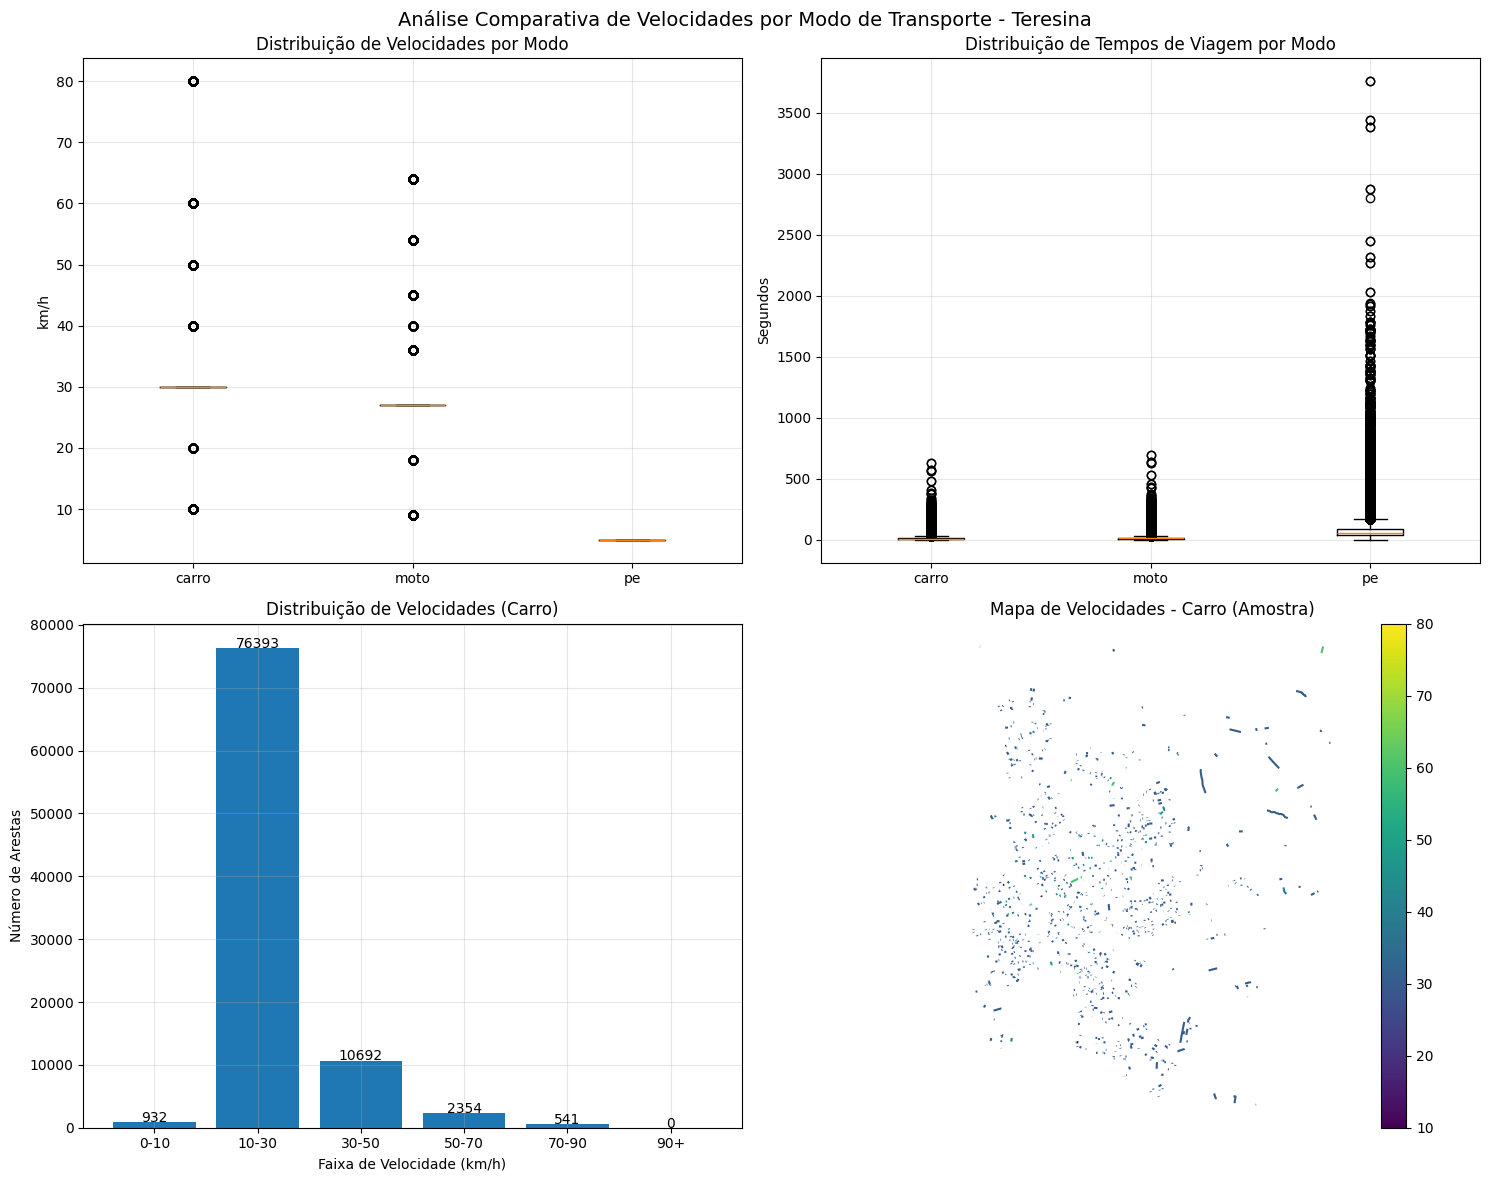

In [45]:
# ============================================
# CÉLULA 8: VISUALIZAÇÃO DOS RESULTADOS
# ============================================

# Criar uma figura com 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição de velocidades por modo
modos = ['carro', 'moto', 'pe']
velocidades = []

for modo in modos:
    edges_temp = ox.convert.graph_to_gdfs(eval(f'G_{modo}'), nodes=False)
    edges_temp = edges_temp.reset_index()
    velocidades.append(edges_temp[f'speed_kph_{modo}'])

axes[0, 0].boxplot(velocidades, labels=modos)
axes[0, 0].set_title('Distribuição de Velocidades por Modo')
axes[0, 0].set_ylabel('km/h')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribuição de tempos de viagem por modo
tempos = []
for modo in modos:
    edges_temp = ox.convert.graph_to_gdfs(eval(f'G_{modo}'), nodes=False)
    edges_temp = edges_temp.reset_index()
    tempos.append(edges_temp[f'travel_time_{modo}'])

axes[0, 1].boxplot(tempos, labels=modos)
axes[0, 1].set_title('Distribuição de Tempos de Viagem por Modo')
axes[0, 1].set_ylabel('Segundos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Proporção de arestas por faixa de velocidade (carro)
if 'speed_kph_carro' in edges_carro.columns:
    bins = [0, 10, 30, 50, 70, 90, 110]
    labels = ['0-10', '10-30', '30-50', '50-70', '70-90', '90+']
    edges_carro['faixa_vel'] = pd.cut(edges_carro['speed_kph_carro'], bins=bins, labels=labels)
    contagem = edges_carro['faixa_vel'].value_counts().sort_index()
    
    axes[1, 0].bar(contagem.index, contagem.values)
    axes[1, 0].set_title('Distribuição de Velocidades (Carro)')
    axes[1, 0].set_xlabel('Faixa de Velocidade (km/h)')
    axes[1, 0].set_ylabel('Número de Arestas')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(contagem.values):
        axes[1, 0].text(i, v + 10, str(v), ha='center')

# 4. Mapa de velocidades (amostra reduzida para performance)
if len(edges_carro) > 1000:
    edges_amostra = edges_carro.sample(1000, random_state=42)
else:
    edges_amostra = edges_carro

edges_amostra.plot(column='speed_kph_carro', 
                   ax=axes[1, 1], 
                   legend=True,
                   cmap='viridis',
                   linewidth=1.5)
axes[1, 1].set_title('Mapa de Velocidades - Carro (Amostra)')
axes[1, 1].axis('off')

plt.suptitle('Análise Comparativa de Velocidades por Modo de Transporte - Teresina', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# CÉLULA 9: SALVAR OS GRAFOS PROCESSADOS
# ============================================

import os
from datetime import datetime

# Criar diretório para salvar se não existir
diretorio_saida = '../dados/processados/osmnx/'
if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)

# Salvar cada grafo individualmente
arquivos_salvos = []

for modo in ['carro', 'moto', 'pe']:
    nome_arquivo = f'{diretorio_saida}rede_teresina_{modo}.graphml'
    grafo = eval(f'G_{modo}')
    ox.io.save_graphml(grafo, filepath=nome_arquivo)
    arquivos_salvos.append(nome_arquivo)
    print(f"✓ Salvo: {nome_arquivo}")

# Também salvar um resumo em CSV para análise
resumo_data = []
for modo in ['carro', 'moto', 'pe']:
    edges_temp = ox.convert.graph_to_gdfs(eval(f'G_{modo}'), nodes=False)
    edges_temp = edges_temp.reset_index()
    
    resumo_data.append({
        'modo': modo,
        'n_nos': len(eval(f'G_{modo}').nodes),
        'n_arestas': len(eval(f'G_{modo}').edges),
        'vel_media': edges_temp[f'speed_kph_{modo}'].mean(),
        'vel_min': edges_temp[f'speed_kph_{modo}'].min(),
        'vel_max': edges_temp[f'speed_kph_{modo}'].max(),
        'tempo_medio': edges_temp[f'travel_time_{modo}'].mean(),
    })

resumo_df = pd.DataFrame(resumo_data)
resumo_csv = f'{diretorio_saida}/resumo_velocidades.csv'
resumo_df.to_csv(resumo_csv, index=False)
print(f"\n✓ Resumo salvo: {resumo_csv}")

print(f"\n📁 Todos os arquivos salvos em: '{diretorio_saida}/'")
print("   Você pode usar esses arquivos nos próximos notebooks.")

✓ Salvo: ../dados/processados/osmnx//rede_teresina_carro.graphml
✓ Salvo: ../dados/processados/osmnx//rede_teresina_moto.graphml
✓ Salvo: ../dados/processados/osmnx//rede_teresina_pe.graphml

✓ Resumo salvo: ../dados/processados/osmnx//resumo_velocidades.csv

📁 Todos os arquivos salvos em: '../dados/processados/osmnx//'
   Você pode usar esses arquivos nos próximos notebooks.


In [50]:
# Também salvar um grafo consolidado com todos os tempos
# (Para evitar repetição, podemos criar um grafo com todas as colunas)
G_consolidado = G_carro.copy()

# Copiar atributos de moto e a pé para o grafo consolidado
for u, v, k in G_consolidado.edges(keys=True):
    for atributo in ['speed_kph_moto', 'travel_time_moto', 
                     'speed_kph_pe', 'travel_time_pe']:
        if atributo in G_moto[u][v][k]:
            G_consolidado[u][v][k][atributo] = G_moto[u][v][k][atributo]
        elif atributo in G_pe[u][v][k]:
             G_consolidado[u][v][k][atributo] = G_pe[u][v][k][atributo]

print("\n4. rede_teresina_todos_modos.graphml (consolidado)")


4. rede_teresina_todos_modos.graphml (consolidado)


In [51]:
ox.io.save_graphml(G_consolidado, filepath='../dados/processados/osmnx/rede_teresina_todos_modos.graphml')

ox.io.save_graph_geopackage(G_consolidado, filepath='../dados/processados/osmnx/rede_teresina_todos_modos.gpkg')

Versão antiga do OSMnx - usando método alternativo
Nó central selecionado: 1521400922
Coordenadas do nó: 9438540.9780, 743309.8451

Calculando isócronas para carro...
  Usando método alternativo para 300s...
  Usando método alternativo para 600s...
  Usando método alternativo para 900s...

Calculando isócronas para moto...
  Usando método alternativo para 300s...
  Usando método alternativo para 600s...
  Usando método alternativo para 900s...

Calculando isócronas para pe...
  Usando método alternativo para 300s...
  Usando método alternativo para 600s...
  Usando método alternativo para 900s...


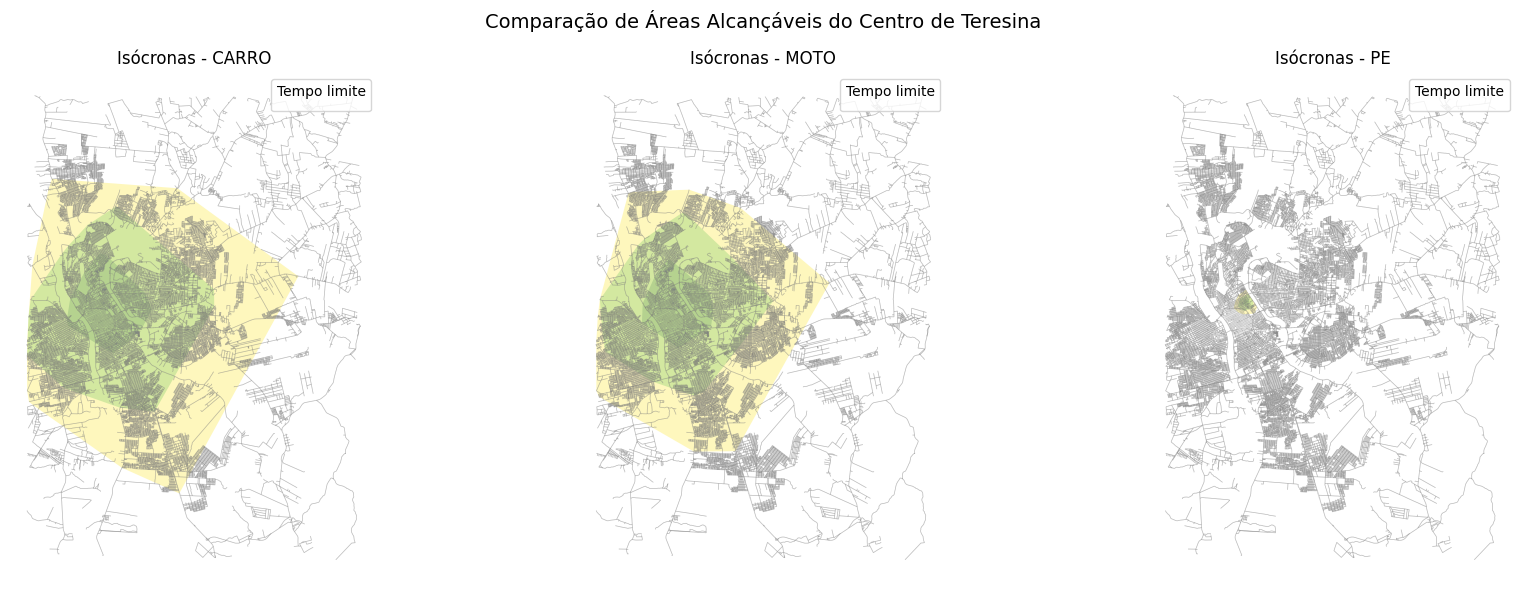

In [56]:
# ============================================
# CÉLULA 10: VALIDAÇÃO COM ISÓCRONAS (CORRIGIDA)
# ============================================

# Importar o submódulo isochrone corretamente
try:
    # Para versões mais recentes do OSMnx (>= 1.0)
    from osmnx import isochrone
    print("Usando osmnx.isochrone (versão recente)")
except ImportError:
    # Para versões mais antigas
    print("Versão antiga do OSMnx - usando método alternativo")

# Testar com um ponto central para validar os tempos
#ubs_aleatoria = (-42.805222,-5.08)  # UBS Por enquanto
ubs_aleatoria = (743331.39912500, 9438521.82289124)  # UBS Por enquanto (UTM ZONA 23 Sul)


# Encontrar nó mais próximo (usar um grafo projetado para precisão)
G_proj = ox.project_graph(G_consolidado)  # Usar G_carro como base
no_centro = ox.distance.nearest_nodes(G_proj, ubs_aleatoria[0], ubs_aleatoria[1])

print(f"Nó central selecionado: {no_centro}")
print(f"Coordenadas do nó: {G_proj.nodes[no_centro]['y']:.4f}, {G_proj.nodes[no_centro]['x']:.4f}")

# Calcular isócronas de 5, 10 e 15 minutos para cada modo
tempos = [300, 600, 900]  # 5, 10, 15 minutos em segundos

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, modo in enumerate(['carro', 'moto', 'pe']):
    print(f"\nCalculando isócronas para {modo}...")
    
    # Determinar qual grafo usar
    if modo == 'carro':
        grafo_modo = G_carro
    elif modo == 'moto':
        grafo_modo = G_moto
    else:
        grafo_modo = G_pe
    
    # Projetar o grafo para este modo
    G_modo_proj = ox.project_graph(grafo_modo)
    
    for tempo in tempos:
        try:
            # Tentar método padrão do OSMnx (para versões recentes)
            isocrona = ox.isochrone.isochrone(
                G_modo_proj, 
                no_centro, 
                tempo, 
                weight=f'travel_time_{modo}'
            )
            
            # Plotar a isócrona
            isocrona.plot(ax=axes[idx], alpha=0.3, 
                         label=f'{tempo//60} min', 
                         color=plt.cm.viridis(tempo/900))
            
        except AttributeError:
            # Método alternativo: usar NetworkX para encontrar nós alcançáveis
            print(f"  Usando método alternativo para {tempo}s...")
            
            # Encontrar todos os nós alcançáveis dentro do tempo limite
            distancias = nx.single_source_dijkstra_path_length(
                G_modo_proj, 
                no_centro, 
                cutoff=tempo, 
                weight=f'travel_time_{modo}'
            )
            
            # Pegar apenas os nós alcançáveis
            nos_alcancaveis = list(distancias.keys())
            
            if len(nos_alcancaveis) > 0:
                # Pegar as coordenadas desses nós
                coordenadas = []
                for no in nos_alcancaveis:
                    if 'x' in G_modo_proj.nodes[no] and 'y' in G_modo_proj.nodes[no]:
                        coordenadas.append((
                            G_modo_proj.nodes[no]['x'],
                            G_modo_proj.nodes[no]['y']
                        ))
                
                if len(coordenadas) >= 3:
                    # Criar um polígono convex hull (como no artigo)
                    from shapely.geometry import MultiPoint
                    from shapely.ops import unary_union
                    
                    pontos = MultiPoint(coordenadas)
                    hull = pontos.convex_hull
                    
                    # Converter para GeoDataFrame para plotar
                    isocrona_gdf = gpd.GeoDataFrame(
                        {'geometry': [hull]}, 
                        crs=G_modo_proj.graph['crs']
                    )
                    
                    isocrona_gdf.plot(ax=axes[idx], alpha=0.3, 
                                     label=f'{tempo//60} min', 
                                     color=plt.cm.viridis(tempo/900))
    
    # Plotar a rede de fundo (amostra para não sobrecarregar)
    edges_gdf_proj = ox.convert.graph_to_gdfs(G_modo_proj, nodes=False)
    
    # Amostrar para visualização mais rápida
    if len(edges_gdf_proj) > 100000:
        edges_plot = edges_gdf_proj.sample(50000, random_state=42)
    else:
        edges_plot = edges_gdf_proj
        
    edges_plot.plot(ax=axes[idx], linewidth=0.5, color='gray', alpha=0.3)
    
    axes[idx].set_title(f'Isócronas - {modo.upper()}')
    axes[idx].legend(title='Tempo limite')
    axes[idx].axis('off')

plt.suptitle('Comparação de Áreas Alcançáveis do Centro de Teresina', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
# ============================================
# CÉLULA 10: VISUALIZAÇÃO CARTOGRÁFICA DAS ISÓCRONAS
# ============================================

# Importar bibliotecas adicionais para melhor visualização
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Testar com um ponto central para validar os tempos
centro_teresina = (743331.39912500, 9438521.82289124)  # Ponto de uma ubs no bairro por enquanto, p´roximo ao rio poti

# Encontrar nó mais próximo (usar um grafo projetado para precisão)
G_proj = ox.project_graph(G_carro)  # Usar G_carro como base
no_centro = ox.distance.nearest_nodes(G_proj, centro_teresina[0], centro_teresina[1])

# Coordenadas do nó central
centro_coords = (G_proj.nodes[no_centro]['x'], G_proj.nodes[no_centro]['y'])

print(f"📍 Nó central: {no_centro}")
print(f"   Coordenadas: {centro_coords[1]:.8f} E, {centro_coords[0]:.8f} N")

# Calcular isócronas de 5, 10 e 15 minutos para cada modo
tempos_minutos = [5, 10, 15]
tempos_segundos = [t * 60 for t in tempos_minutos]

# Criar uma figura com layout mais cartográfico
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Paleta de cores para isócronas (de claro para escuro)
cores_isocronas = ['#FFE0E0', '#FF9999', '#FF3333']  # Tons de vermelho

# ============================================
# SUBPLOT 1: MAPA COMPARATIVO DOS TRÊS MODOS (5 min)
# ============================================
ax1 = axes[0, 0]

# Primeiro, plotar a rede viária completa como base
edges_gdf_proj = ox.convert.graph_to_gdfs(G_proj, nodes=False)

# Dividir a rede por tipo de via para visualização hierárquica
vias_principais = edges_gdf_proj[edges_gdf_proj['highway'].apply(
    lambda x: isinstance(x, str) and any(tipo in x for tipo in ['motorway', 'trunk', 'primary'])
)]
vias_secundarias = edges_gdf_proj[edges_gdf_proj['highway'].apply(
    lambda x: isinstance(x, str) and any(tipo in x for tipo in ['secondary', 'tertiary'])
)]
vias_locais = edges_gdf_proj[edges_gdf_proj['highway'].apply(
    lambda x: isinstance(x, str) and any(tipo in x for tipo in ['residential', 'service', 'unclassified'])
)]

# Plotar em ordem de importância (locais primeiro, principais por último)
vias_locais.plot(ax=ax1, linewidth=0.3, color='lightgray', alpha=0.5, label='Vias locais')
vias_secundarias.plot(ax=ax1, linewidth=0.8, color='gray', alpha=0.7, label='Vias secundárias')
vias_principais.plot(ax=ax1, linewidth=1.5, color='black', alpha=0.9, label='Vias principais')

# Calcular e plotar isócronas de 5 minutos para cada modo
# for idx, modo in enumerate(['carro', 'moto', 'pe']):
#     if modo == 'carro':
#         grafo_modo = G_carro
#         cor = 'blue'
#         label = 'Carro'
#     elif modo == 'moto':
#         grafo_modo = G_moto
#         cor = 'orange'
#         label = 'Moto'
#     else:
#         grafo_modo = G_pe
#         cor = 'green'
#         label = 'A pé'
    
#     G_modo_proj = ox.project_graph(grafo_modo)
    
#     try:
#         # Isócrona de 5 minutos (300 segundos)
#         isocrona = ox.isochrone.isochrone(
#             G_modo_proj, 
#             no_centro, 
#             300, 
#             weight=f'travel_time_{modo}'
#         )
        
#         # Plotar com estilo diferenciado
#         isocrona.plot(ax=ax1, alpha=0.4, color=cor, 
#                      edgecolor=cor, linewidth=1.5,
#                      label=f'{label} (5 min)')
        
#     except Exception as e:
#         print(f"Erro ao calcular isócrona para {modo}: {e}")

# Calcular isócronas de 5, 10 e 15 minutos para cada modo
tempos = [300, 600, 900]  # 5, 10, 15 minutos em segundos

for idx, modo in enumerate(['carro', 'moto', 'pe']):
    print(f"\nCalculando isócronas para {modo}...")
    
    # Determinar qual grafo usar
    if modo == 'carro':
        grafo_modo = G_carro
        cor = 'blue'
        label = 'Carro'
    elif modo == 'moto':
        grafo_modo = G_moto
        cor = 'orange'
        label = 'Moto'
    else:
        grafo_modo = G_pe
        cor = 'green'
        label = 'A pé'
    
    # Projetar o grafo para este modo
    G_modo_proj = ox.project_graph(grafo_modo)
    
    for tempo in tempos:
        try:
            # Tentar método padrão do OSMnx (para versões recentes)
            isocrona = ox.isochrone.isochrone(
                G_modo_proj, 
                no_centro, 
                300, 
                weight=f'travel_time_{modo}'
            )
            
            # Plotar a isócrona
            isocrona.plot(ax=ax1, alpha=0.4, 
                         label=f'{tempo//60} min', 
                         color=plt.cm.viridis(tempo/900))

            # Plotar com estilo diferenciado
            # isocrona.plot(ax=ax1, alpha=0.4, color=cor, edgecolor=cor, linewidth=1.5, label=f'{label} (5 min)')
            
        except AttributeError:
            # Método alternativo: usar NetworkX para encontrar nós alcançáveis
            print(f"  Usando método alternativo para {tempo}s...")
            
            # Encontrar todos os nós alcançáveis dentro do tempo limite
            distancias = nx.single_source_dijkstra_path_length(
                G_modo_proj, 
                no_centro, 
                cutoff=300, 
                weight=f'travel_time_{modo}'
            )
            
            # Pegar apenas os nós alcançáveis
            nos_alcancaveis = list(distancias.keys())
            
            if len(nos_alcancaveis) > 0:
                # Pegar as coordenadas desses nós
                coordenadas = []
                for no in nos_alcancaveis:
                    if 'x' in G_modo_proj.nodes[no] and 'y' in G_modo_proj.nodes[no]:
                        coordenadas.append((
                            G_modo_proj.nodes[no]['x'],
                            G_modo_proj.nodes[no]['y']
                        ))
                
                if len(coordenadas) >= 3:
                    # Criar um polígono convex hull (como no artigo)
                    from shapely.geometry import MultiPoint
                    from shapely.ops import unary_union
                    
                    pontos = MultiPoint(coordenadas)
                    hull = pontos.convex_hull
                    
                    # Converter para GeoDataFrame para plotar
                    isocrona_gdf = gpd.GeoDataFrame(
                        {'geometry': [hull]}, 
                        crs=G_modo_proj.graph['crs']
                    )
                    
                    isocrona_gdf.plot(ax=axes[idx], alpha=0.4, 
                                     label=f'{tempo//60} min', 
                                     color=plt.cm.viridis(tempo/900))

# Adicionar ponto central
ax1.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=200, marker='*', 
           edgecolor='black', linewidth=1.5,
           label='Ponto central', zorder=10)

ax1.set_title('Área Alcançável em 5 Minutos por Modo de Transporte', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')

# ============================================
# SUBPLOT 2: ISÓCRONAS ESCALONADAS PARA CARRO
# ============================================
ax2 = axes[0, 1]

# Plotar rede base (apenas principais para não poluir)
vias_principais.plot(ax=ax2, linewidth=1.2, color='darkgray', alpha=0.7)

# Calcular e plotar isócronas escalonadas para carro
G_carro_proj = ox.project_graph(G_carro)

for i, tempo in enumerate(tempos_segundos):
    try:
        isocrona = ox.isochrone.isochrone(
            G_carro_proj, 
            no_centro, 
            tempo, 
            weight='travel_time_carro'
        )
        
        # Plotar com cor gradiente
        isocrona.plot(ax=ax2, alpha=0.3, 
                     color=cores_isocronas[i],
                     edgecolor=cores_isocronas[i], linewidth=1,
                     label=f'{tempo//60} minutos')
        
    except Exception as e:
        print(f"Erro ao calcular isócrona de {tempo//60}min para carro: {e}")

# Ponto central
ax2.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=150, marker='*', 
           edgecolor='black', linewidth=1)

ax2.set_title('Isócronas de Acesso por Carro (Centro de Teresina)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

# ============================================
# SUBPLOT 3: ISÓCRONAS ESCALONADAS PARA A PÉ
# ============================================
ax3 = axes[1, 0]

# Plotar rede base (vias locais são mais importantes para pedestres)
vias_locais.plot(ax=ax3, linewidth=0.8, color='lightgray', alpha=0.8)

G_pe_proj = ox.project_graph(G_pe)

for i, tempo in enumerate(tempos_segundos):
    try:
        isocrona = ox.isochrone.isochrone(
            G_pe_proj, 
            no_centro, 
            tempo, 
            weight='travel_time_pe'
        )
        
        isocrona.plot(ax=ax3, alpha=0.4, 
                     color=['#E0FFE0', '#99FF99', '#33FF33'][i],
                     edgecolor='green', linewidth=0.8,
                     label=f'{tempo//60} minutos')
        
    except Exception as e:
        print(f"Erro ao calcular isócrona de {tempo//60}min para a pé: {e}")

# Ponto central
ax3.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=150, marker='*', 
           edgecolor='black', linewidth=1)

ax3.set_title('Isócronas de Acesso a Pé (Centro de Teresina)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.2)

# ============================================
# SUBPLOT 4: ANÁLISE COMPARATIVA DE ÁREAS
# ============================================
ax4 = axes[1, 1]

# Calcular áreas para análise comparativa
areas_por_modo = {}
labels_areas = []

for modo in ['carro', 'moto', 'pe']:
    areas = []
    grafo = eval(f'G_{modo}')
    G_modo_proj = ox.project_graph(grafo)
    
    for tempo in tempos_segundos:
        try:
            isocrona = ox.isochrone.isochrone(
                G_modo_proj, 
                no_centro, 
                tempo, 
                weight=f'travel_time_{modo}'
            )
            # Calcular área em km²
            area_km2 = isocrona.to_crs(epsg=31985).area.sum() / 1_000_000
            areas.append(area_km2)
        except:
            areas.append(0)
    
    areas_por_modo[modo] = areas
    labels_areas.append(modo.upper())

# Gráfico de barras comparativo
x = np.arange(len(tempos_minutos))
width = 0.25

for i, (modo, areas) in enumerate(areas_por_modo.items()):
    offset = (i - 1) * width
    if modo == 'carro':
        cor = 'blue'
    elif modo == 'moto':
        cor = 'orange'
    else:
        cor = 'green'
    
    ax4.bar(x + offset, areas, width, label=modo.upper(), color=cor, alpha=0.7)

ax4.set_xlabel('Tempo de Viagem (minutos)')
ax4.set_ylabel('Área Alcançável (km²)')
ax4.set_title('Área Alcançável por Modo e Tempo', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(tempos_minutos)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (modo, areas) in enumerate(areas_por_modo.items()):
    offset = (i - 1) * width
    for j, area in enumerate(areas):
        ax4.text(j + offset, area + 0.1, f'{area:.1f}', 
                ha='center', va='bottom', fontsize=9)

# ============================================
# AJUSTES GERAIS DA FIGURA
# ============================================
plt.suptitle('Análise de Acessibilidade a partir do Centro de Teresina\n' +
             'Comparativo entre Modos de Transporte (Carro, Moto, A Pé)', 
             fontsize=16, fontweight='bold', y=1.02)

# Adicionar uma legenda explicativa geral
legenda_texto = (
    "📌 Ponto central: Centro aproximado de Teresina\n"
    "🚗 Carro: Baseado em velocidades de 20-100 km/h conforme tipo de via\n"
    "🏍️ Moto: Velocidades ≈ 80-90% das velocidades do carro\n"
    "🚶 A pé: Velocidade constante de 5 km/h\n"
    "🗺️ Isócronas: Áreas alcançáveis dentro dos tempos indicados"
)

fig.text(0.02, 0.02, legenda_texto, fontsize=10, 
         verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# ============================================
# INFORMAÇÕES NUMÉRICAS ADICIONAIS
# ============================================
print("\n" + "="*60)
print("📊 RESUMO NUMÉRICO DAS ÁREAS ALCANÇÁVEIS")
print("="*60)

print(f"\n📍 Ponto de partida: {centro_coords[1]:.4f}°S, {centro_coords[0]:.4f}°W")
print("   (Centro aproximado de Teresina)")

for modo, areas in areas_por_modo.items():
    nome_modo = {'carro': 'Carro', 'moto': 'Moto', 'pe': 'A pé'}[modo]
    print(f"\n{nome_modo}:")
    for i, (tempo_min, area) in enumerate(zip(tempos_minutos, areas)):
        print(f"  • {tempo_min} min: {area:.2f} km²")
    
    # Calcular taxa de expansão (entre 5 e 15 minutos)
    if areas[2] > 0 and areas[0] > 0:
        expansao = (areas[2] / areas[0]) * 100
        print(f"  📈 Expansão 5→15min: {expansao:.0f}%")

print("\n" + "="*60)

📍 Nó central: 1521400922
   Coordenadas: 9438540.97797776 E, 743309.84510548 N

Calculando isócronas para carro...
  Usando método alternativo para 300s...


AttributeError: 'numpy.ndarray' object has no attribute 'set_aspect'

📍 Nó central: 1521400922
   Coordenadas: -5.075831°S, -42.805417°W
   (Centro aproximado de Teresina)

Calculando isócronas para CARRO...
Calculando isócronas para MOTO...
Calculando isócronas para A PÉ...


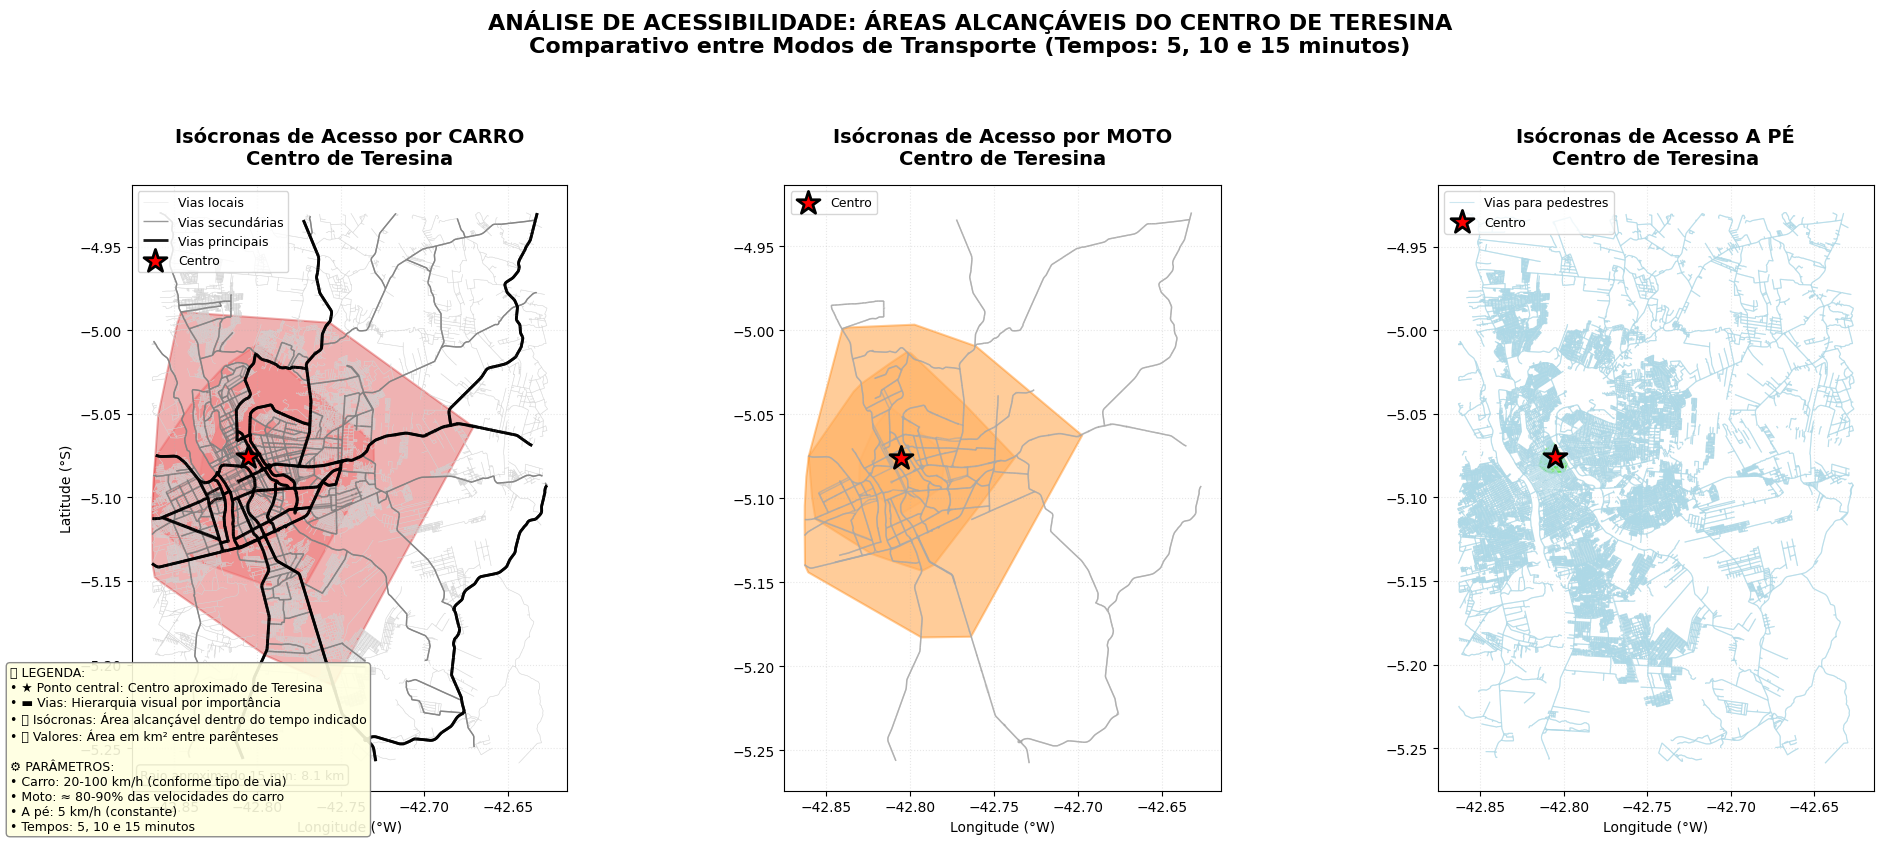


📈 ANÁLISE QUANTITATIVA DAS ÁREAS ALCANÇÁVEIS

Modo        5 min (km²) 10 min (km²) 15 min (km²)  Expansão 5→15 min
----------------------------------------------------------------------
CARRO              33.5        160.7        366.5               995%
MOTO               26.1        124.5        272.5               943%
A PÉ              966.1        966.1        966.1                 0%

💡 INTERPRETAÇÃO:

1. CARRO: Maior área coberta devido às maiores velocidades.
2. MOTO: Área ligeiramente menor que o carro (≈80-90% da velocidade).
3. A PÉ: Área muito menor, limitada pela velocidade de caminhada.
4. EXPANSÃO: Mostra como a área cresce com o tempo adicional.
   • Exemplo: Se expansão = 300%, a área com 15 min é 4x maior que com 5 min.


📝 PARA SUA PESQUISA (A2SFCA):
• Estas isócronas serão calculadas para CADA UBS
• O método A2SFCA usará a SOBREPOSIÇÃO entre isócronas e setores censitários
• População será ponderada pela % de área sobreposta
• Você repetirá este processo para todos

In [36]:
# ============================================
# CÉLULA 10: VISUALIZAÇÃO CARTOGRÁFICA DAS ISÓCRONAS (VERSÃO SIMPLIFICADA)
# ============================================

import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from shapely.geometry import MultiPoint

# Função para calcular isócronas manualmente (sem o módulo isochrone)
def calcular_isocrona_manual(grafo, no_origem, tempo_limite, peso='travel_time'):
    """
    Calcula a isócrona (polígono convexo) de todos os nós alcançáveis
    a partir de um nó de origem dentro de um limite de tempo.
    """
    # Encontrar todos os nós alcançáveis dentro do tempo limite usando Dijkstra
    distancias = nx.single_source_dijkstra_path_length(
        grafo, 
        no_origem, 
        cutoff=tempo_limite, 
        weight=peso
    )
    
    # Coletar coordenadas dos nós alcançáveis
    coordenadas = []
    for no, dist in distancias.items():
        if 'x' in grafo.nodes[no] and 'y' in grafo.nodes[no]:
            coordenadas.append((grafo.nodes[no]['x'], grafo.nodes[no]['y']))
    
    # Se não houver nós suficientes, retornar None
    if len(coordenadas) < 3:
        return None
    
    # Criar um polígono convexo (convex hull) a partir dos pontos
    pontos = MultiPoint(coordenadas)
    convex_hull = pontos.convex_hull
    
    # Converter para GeoDataFrame
    isocrona_gdf = gpd.GeoDataFrame(
        {'geometry': [convex_hull]}, 
        crs=grafo.graph['crs'] if 'crs' in grafo.graph else 'EPSG:4326'
    )
    
    return isocrona_gdf

# Testar com um ponto central para validar os tempos
centro_teresina = (-42.80523,-5.07622)  # Ponto aproximado do centro

# Encontrar nó mais próximo
no_centro = ox.distance.nearest_nodes(G_carro, centro_teresina[0], centro_teresina[1])

# Coordenadas do nó central
centro_coords = (G_carro.nodes[no_centro]['x'], G_carro.nodes[no_centro]['y'])

print(f"📍 Nó central: {no_centro}")
print(f"   Coordenadas: {centro_coords[1]:.6f}°S, {centro_coords[0]:.6f}°W")
print(f"   (Centro aproximado de Teresina)")

# Calcular isócronas de 5, 10 e 15 minutos para cada modo
tempos_minutos = [5, 10, 15]
tempos_segundos = [t * 60 for t in tempos_minutos]

# Criar uma figura com layout cartográfico
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# ============================================
# 1. ISÓCRONAS PARA CARRO
# ============================================
ax1 = axes[0]
print("\nCalculando isócronas para CARRO...")

# Primeiro, plotar a rede viária completa como base
edges_gdf_carro = ox.convert.graph_to_gdfs(G_carro, nodes=False)
edges_gdf_carro = edges_gdf_carro.reset_index()

# Dividir a rede por tipo de via para visualização hierárquica
# Primeiro precisamos limpar os tipos de via (alguns são listas)
def limpar_tipo_via(valor):
    if isinstance(valor, list):
        return valor[0]
    return valor

edges_gdf_carro['highway_clean'] = edges_gdf_carro['highway'].apply(limpar_tipo_via)

# Separar vias por importância
vias_principais = edges_gdf_carro[edges_gdf_carro['highway_clean'].str.contains('motorway|trunk|primary', na=False)]
vias_secundarias = edges_gdf_carro[edges_gdf_carro['highway_clean'].str.contains('secondary|tertiary', na=False)]
vias_locais = edges_gdf_carro[edges_gdf_carro['highway_clean'].str.contains('residential|service|unclassified|living', na=False)]

# Plotar em ordem de importância
vias_locais.plot(ax=ax1, linewidth=0.4, color='lightgray', alpha=0.6, label='Vias locais')
vias_secundarias.plot(ax=ax1, linewidth=1.0, color='gray', alpha=0.8, label='Vias secundárias')
vias_principais.plot(ax=ax1, linewidth=2.0, color='black', alpha=0.9, label='Vias principais')

# Calcular e plotar isócronas escalonadas para carro
cores_isocronas = ['#FFCCCC', '#FF6666', '#CC0000']  # Tons de vermelho

for i, tempo in enumerate(tempos_segundos):
    isocrona = calcular_isocrona_manual(G_carro, no_centro, tempo, peso='travel_time_carro')
    
    if isocrona is not None:
        # Calcular área para a legenda
        area_km2 = isocrona.to_crs(epsg=31985).area.sum() / 1_000_000
        
        # Plotar a isócrona
        isocrona.plot(ax=ax1, alpha=0.3, 
                     color=cores_isocronas[i],
                     edgecolor=cores_isocronas[i], 
                     linewidth=1.5,
                     label=f'{tempo//60} min ({area_km2:.1f} km²)')

# Adicionar ponto central
ax1.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=300, marker='*', 
           edgecolor='black', linewidth=2,
           label='Centro', zorder=10)

ax1.set_title('Isócronas de Acesso por CARRO\nCentro de Teresina', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Longitude (°W)')
ax1.set_ylabel('Latitude (°S)')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.set_aspect('equal')

# Adicionar escala de distância aproximada
# Calcular o raio aproximado para 15 minutos
velocidade_media = edges_gdf_carro['speed_kph_carro'].mean()
raio_km = (velocidade_media * 15/60)  # km em 15 minutos
ax1.text(0.02, 0.02, f'Raio aproximado 15 min: {raio_km:.1f} km',
         transform=ax1.transAxes, fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ============================================
# 2. ISÓCRONAS PARA MOTO
# ============================================
ax2 = axes[1]
print("Calculando isócronas para MOTO...")

# Plotar rede base (simplificada)
edges_gdf_moto = ox.convert.graph_to_gdfs(G_moto, nodes=False)
edges_gdf_moto = edges_gdf_moto.reset_index()

# Usar apenas vias principais para visualização mais limpa
vias_principais_moto = edges_gdf_moto[edges_gdf_moto['highway'].apply(
    lambda x: isinstance(x, str) and any(tipo in str(x) for tipo in ['motorway', 'trunk', 'primary', 'secondary'])
)]
vias_principais_moto.plot(ax=ax2, linewidth=1.0, color='darkgray', alpha=0.7)

# Calcular e plotar isócronas para moto
cores_moto = ['#FFE5CC', '#FFB366', '#FF8000']  # Tons de laranja

for i, tempo in enumerate(tempos_segundos):
    isocrona = calcular_isocrona_manual(G_moto, no_centro, tempo, peso='travel_time_moto')
    
    if isocrona is not None:
        area_km2 = isocrona.to_crs(epsg=31985).area.sum() / 1_000_000
        isocrona.plot(ax=ax2, alpha=0.4, 
                     color=cores_moto[i],
                     edgecolor=cores_moto[i], 
                     linewidth=1.5,
                     label=f'{tempo//60} min ({area_km2:.1f} km²)')

# Ponto central
ax2.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=300, marker='*', 
           edgecolor='black', linewidth=2,
           label='Centro', zorder=10)

ax2.set_title('Isócronas de Acesso por MOTO\nCentro de Teresina', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Longitude (°W)')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.set_aspect('equal')

# ============================================
# 3. ISÓCRONAS PARA A PÉ
# ============================================
ax3 = axes[2]
print("Calculando isócronas para A PÉ...")

# Para pedestres, mostrar vias locais (mais relevantes)
edges_gdf_pe = ox.convert.graph_to_gdfs(G_pe, nodes=False)
edges_gdf_pe = edges_gdf_pe.reset_index()

# Filtrar apenas vias onde pedestres podem circular (velocidade > 0)
vias_pe = edges_gdf_pe[edges_gdf_pe['speed_kph_pe'] > 0]
vias_pe.plot(ax=ax3, linewidth=0.8, color='lightblue', alpha=0.6, label='Vias para pedestres')

# Calcular e plotar isócronas para a pé
cores_pe = ['#CCFFCC', '#66FF66', '#00CC00']  # Tons de verde

for i, tempo in enumerate(tempos_segundos):
    isocrona = calcular_isocrona_manual(G_pe, no_centro, tempo, peso='travel_time_pe')
    
    if isocrona is not None:
        area_km2 = isocrona.to_crs(epsg=31985).area.sum() / 1_000_000
        isocrona.plot(ax=ax3, alpha=0.4, 
                     color=cores_pe[i],
                     edgecolor=cores_pe[i], 
                     linewidth=1.5,
                     label=f'{tempo//60} min ({area_km2:.1f} km²)')

# Ponto central
ax3.scatter(centro_coords[0], centro_coords[1], 
           c='red', s=300, marker='*', 
           edgecolor='black', linewidth=2,
           label='Centro', zorder=10)

ax3.set_title('Isócronas de Acesso A PÉ\nCentro de Teresina', 
              fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Longitude (°W)')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3, linestyle=':')
ax3.set_aspect('equal')

# ============================================
# AJUSTES GERAIS DA FIGURA
# ============================================
plt.suptitle('ANÁLISE DE ACESSIBILIDADE: ÁREAS ALCANÇÁVEIS DO CENTRO DE TERESINA\n' +
             'Comparativo entre Modos de Transporte (Tempos: 5, 10 e 15 minutos)', 
             fontsize=16, fontweight='bold', y=1.05)

# Adicionar uma legenda explicativa geral
legenda_texto = (
    "📊 LEGENDA:\n"
    "• ★ Ponto central: Centro aproximado de Teresina\n"
    "• ▬ Vias: Hierarquia visual por importância\n"
    "• 🎯 Isócronas: Área alcançável dentro do tempo indicado\n"
    "• 📐 Valores: Área em km² entre parênteses\n"
    "\n"
    "⚙️ PARÂMETROS:\n"
    "• Carro: 20-100 km/h (conforme tipo de via)\n"
    "• Moto: ≈ 80-90% das velocidades do carro\n"
    "• A pé: 5 km/h (constante)\n"
    "• Tempos: 5, 10 e 15 minutos"
)

fig.text(0.02, 0.02, legenda_texto, fontsize=9, 
         verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.show()

# ============================================
# ANÁLISE QUANTITATIVA
# ============================================
print("\n" + "="*70)
print("📈 ANÁLISE QUANTITATIVA DAS ÁREAS ALCANÇÁVEIS")
print("="*70)

# Calcular áreas para análise comparativa
areas_comparativas = {}

for modo, grafo in [('CARRO', G_carro), ('MOTO', G_moto), ('A PÉ', G_pe)]:
    areas = []
    for tempo in tempos_segundos:
        isocrona = calcular_isocrona_manual(grafo, no_centro, tempo, 
                                           peso=f'travel_time_{modo.lower().replace(" ", "_").replace("é", "e")}')
        if isocrona is not None:
            area_km2 = isocrona.to_crs(epsg=31985).area.sum() / 1_000_000
            areas.append(area_km2)
        else:
            areas.append(0)
    
    areas_comparativas[modo] = areas

# Exibir tabela comparativa
print(f"\n{'Modo':<10} {'5 min (km²)':>12} {'10 min (km²)':>12} {'15 min (km²)':>12} {'Expansão 5→15 min':>18}")
print("-" * 70)

for modo, areas in areas_comparativas.items():
    expansao = ((areas[2] - areas[0]) / areas[0] * 100) if areas[0] > 0 else 0
    print(f"{modo:<10} {areas[0]:>12.1f} {areas[1]:>12.1f} {areas[2]:>12.1f} {expansao:>17.0f}%")

print("\n" + "="*70)
print("💡 INTERPRETAÇÃO:")
print("="*70)

print("""
1. CARRO: Maior área coberta devido às maiores velocidades.
2. MOTO: Área ligeiramente menor que o carro (≈80-90% da velocidade).
3. A PÉ: Área muito menor, limitada pela velocidade de caminhada.
4. EXPANSÃO: Mostra como a área cresce com o tempo adicional.
   • Exemplo: Se expansão = 300%, a área com 15 min é 4x maior que com 5 min.
""")

# Calcular população aproximada atingida (se tivéssemos dados populacionais)
print("\n📝 PARA SUA PESQUISA (A2SFCA):")
print("""• Estas isócronas serão calculadas para CADA UBS
• O método A2SFCA usará a SOBREPOSIÇÃO entre isócronas e setores censitários
• População será ponderada pela % de área sobreposta
• Você repetirá este processo para todos os modos de transporte""")